array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

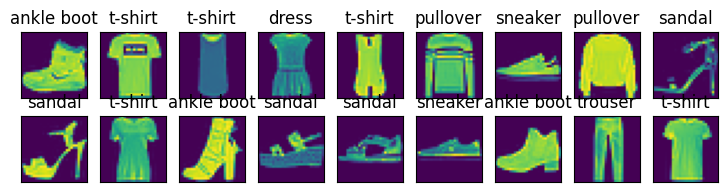

In [7]:
import torch
from torch import nn as nn
from torch.utils import data
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms as transforms
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root=r"C:\Users\Lenovo\Desktop\visiondata", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root=r"C:\Users\Lenovo\Desktop\visiondata", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=12),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=12))
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root=r"C:\Users\Lenovo\Desktop\visiondata", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root=r"C:\Users\Lenovo\Desktop\visiondata", train=False, transform=trans, download=True)
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
def show_images(imgs, num_rows, num_cols, titles=None, scale=1):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            #print(img.squeeze().numpy())
            ax.imshow(img.squeeze().numpy())
        else:
            # PIL图片
            ax.imshow(img)
        
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
        #ax.axis('off')
    return axes
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [18]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), 
                    nn.Linear(784, 10),
                    nn.Softmax(dim=1))

print(net.type)
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

<bound method Module.type of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): Softmax(dim=1)
)>


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): Softmax(dim=1)
)

In [19]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
trainer = torch.optim.SGD(net.parameters(), lr=0.1)
epochs=10
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            #print("Input shape:", X.shape,y.shape)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y

    return (cmp.type(y.dtype).sum())
def train_epoch_ch3(net, train_iter, loss):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    updater=torch.optim.SGD(net.parameters(), lr=0.1)
    #X,y=next(iter(train_iter))
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()
    # else:
    #     # 使用定制的优化器和损失函数
    #     l.sum().backward()
    #     updater(X.shape[0])
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())  # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
def train_ch3(net, train_iter, test_iter, loss, num_epochs):  #@save
    """训练模型（定义见第3章）"""

    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss)
        print(f"epoch:{epoch}",train_metrics[0],train_metrics[1])
        test_acc = evaluate_accuracy(net, test_iter)

    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs)

epoch:0 0.5705235799153646 0.8333333333333334
epoch:1 0.5167417526245117 0.8541666666666666
epoch:2 0.4672144254048665 0.8541666666666666
epoch:3 0.6250601609547933 0.7916666666666666
epoch:4 0.46855608622233075 0.7708333333333334
epoch:5 0.3572562138239543 0.8958333333333334
epoch:6 0.3492439190546672 0.8958333333333334
epoch:7 0.3567405144373576 0.8958333333333334
epoch:8 0.5239689747492472 0.8125
epoch:9 0.34664026896158856 0.875


In [15]:
x,y=next(iter(train_iter))
y_hat=net(x)
print("y",y)
print("y_hat",y_hat,len(y_hat))
loss=cross_entropy(y_hat,y)
print(loss.mean())

y tensor([5, 0, 5, 0, 4, 6, 3, 2, 7, 8, 6, 2, 0, 9, 1, 1, 1, 7, 7, 0, 6, 1, 1, 9,
        9, 7, 1, 8, 5, 1, 4, 2, 6, 3, 4, 0, 0, 9, 0, 5, 5, 4, 5, 1, 2, 3, 6, 2,
        0, 7, 5, 1, 0, 5, 6, 1, 3, 9, 6, 3, 0, 4, 7, 9, 1, 7, 8, 7, 0, 7, 3, 9,
        2, 2, 8, 7, 0, 8, 8, 9, 9, 9, 3, 6, 7, 5, 7, 9, 5, 8, 4, 8, 3, 8, 8, 6,
        2, 0, 1, 1, 4, 0, 9, 7, 7, 2, 4, 3, 4, 4, 8, 3, 3, 9, 0, 9, 7, 2, 6, 2,
        0, 6, 1, 7, 0, 0, 8, 1, 3, 9, 1, 5, 8, 2, 2, 6, 5, 5, 1, 8, 3, 1, 6, 0,
        5, 2, 3, 9, 5, 4, 5, 8, 7, 2, 4, 5, 3, 1, 7, 4, 9, 7, 9, 6, 8, 7, 7, 2,
        6, 4, 9, 4, 4, 1, 1, 0, 6, 5, 1, 7, 7, 7, 2, 0, 1, 0, 5, 0, 3, 1, 3, 5,
        0, 8, 9, 9, 9, 4, 4, 0, 0, 2, 9, 2, 1, 5, 4, 1, 6, 0, 6, 2, 8, 2, 1, 4,
        4, 2, 5, 1, 8, 0, 1, 9, 3, 3, 0, 4, 4, 2, 1, 7, 0, 8, 7, 4, 5, 8, 9, 1,
        9, 7, 8, 6, 6, 0, 5, 5, 0, 9, 5, 4, 2, 1, 2, 2])
y_hat tensor([[ -15.8006,  -14.5406,  -17.2908,  ...,   24.9627,  -22.8013,
          -15.8308],
        [ -84.4206,  -95.1518,  -81.7254,  .

In [14]:
len([5, 1, 4, 7, 6, 9, 4, 4, 1, 2, 1, 7, 1, 3, 0, 9, 6, 8, 1, 0, 7, 8, 6, 9,
        3, 0, 5, 1, 4, 0, 9, 7, 3, 4, 6, 8, 6, 1, 6, 3, 5, 6, 9, 3, 6, 5, 8, 2,
        2, 3, 6, 0, 0, 4, 0, 8, 1, 0, 3, 1, 1, 3, 7, 6, 1, 3, 3, 8, 0, 9, 4, 4,
        7, 7, 1, 7, 7, 2, 2, 1, 0, 3, 1, 0, 9, 5, 0, 5, 1, 8, 8, 5, 7, 7, 5, 7,
        5, 2, 8, 7, 7, 2, 7, 8, 2, 0, 0, 6, 3, 7, 7, 3, 0, 4, 0, 8, 1, 6, 2, 9,
        8, 5, 5, 1, 4, 5, 3, 2, 7, 7, 0, 4, 9, 2, 4, 0, 1, 3, 2, 2, 8, 8, 6, 9,
        5, 9, 1, 4, 1, 7, 7, 4, 4, 3, 5, 4, 5, 5, 6, 4, 7, 4, 1, 0, 3, 6, 2, 8,
        2, 4, 7, 8, 4, 4, 8, 4, 3, 5, 0, 7, 0, 1, 6, 1, 9, 3, 9, 6, 1, 2, 8, 5,
        3, 5, 1, 2, 3, 0, 9, 7, 9, 7, 5, 4, 3, 0, 5, 0, 6, 1, 1, 2, 7, 9, 4, 9,
        2, 9, 2, 6, 5, 0, 0, 3, 5, 8, 2, 2, 2, 0, 3, 3, 5, 8, 8, 7, 2, 0, 8, 6,
        8, 3, 0, 6, 1, 4, 6, 6, 9, 8, 9, 5, 5, 0, 3, 6])

256